In [1]:
from shapes import Point, Rectangle
from environment import Environment2D
from utils import PlotTools, GeoTools
from graph import Graph
from lqr import LQRPlanner
from simulate import Simulator
from plan import Plan, PlanUtils
from search import Searcher

from bitarray import bitarray, frozenbitarray
import time
import matplotlib.pyplot as plt
import numpy as np
import polytope as pc
%load_ext autoreload
%autoreload 2

In [2]:
# def generate_waypoints(A, B, x_0, u_nom):
#     T = u_nom.shape[0]
#     x_nom = np.zeros((T, A.shape[0]))
#     x_nom[0] = x_0
#     for t in range(1, T):
#         x_nom[t] = np.dot(A, x_nom[t - 1]) + np.dot(B, u_nom[t - 1])
#     return x_nom

# Env 0

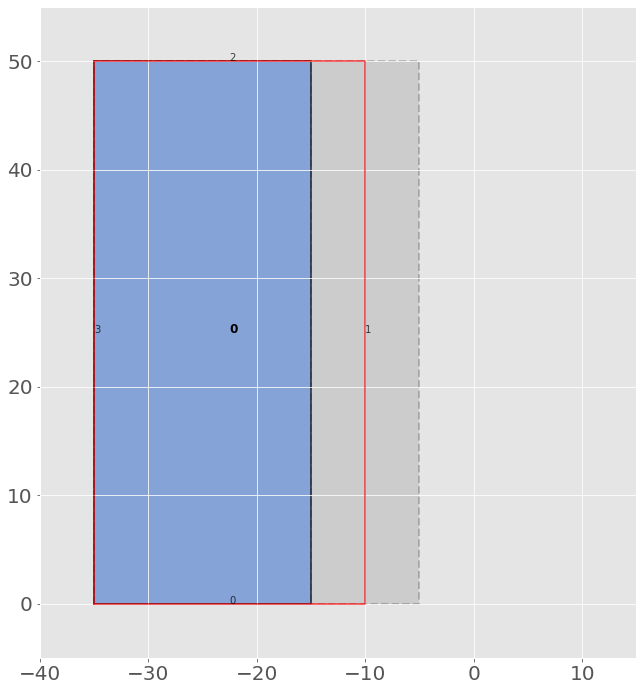

In [63]:
x_lims = [-40,15]
y_lims = [-5,55]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -35,0,25,50,0)
rec_0.set_error_bounds(np.array([0,-5,0,0]), np.array([0,5,0,0]))
rec_0.set_actual_errors(np.array([0,-5,0,0]))
# rec_0.set_actual_errors(np.array([0,5,0,0]))
fig, ax = plt.subplots()
env.add_rectangles([rec_0])
env.plot(ax=ax)
# env.rectangles[0].as_poly["actual"].plot(ax=ax)

In [64]:
dt = 0.2
A = np.eye(2); B = dt*np.eye(2)
Q_lqr = np.eye(2)
R_lqr = 0.1*np.eye(2)
lqr_planner = LQRPlanner(Q_lqr, R_lqr, A, B)

dx = 1
Q = np.eye(2) * 0.05
R = 1
T = 50
x0 = [0,0]

x_est_0 = x0
P_est_0 = np.eye(2)

### Graph exploration

In [65]:
x_range = np.array([x_lims, y_lims])
nsamples = 100
tol = 1e-2
g = Graph(x0, x_range, env, lqr_planner)
g.clear()

In [93]:
samples_all = np.load("samples.dat", allow_pickle=True)
samples_manual = []
for i in [0,22,8,17,18,23,13,47,10,29,11]:
# for i in [0,8,18,13,47,10,29,11]:
    samples_manual.append(samples_all[i,:2])
samples_manual = np.array(samples_manual)
g.set_samples(samples_manual)
# g.set_samples(samples_all)

In [94]:
g.build(nsamples, r=10, max_neighbors=5, tol=tol)

Connecting took: 0.03 s.


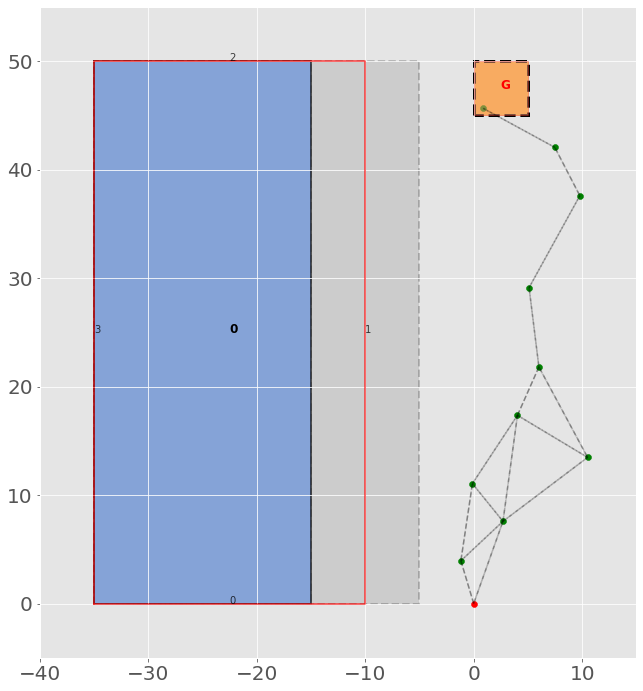

In [95]:
scaling_factors = [6,5,4,3,2,1]
fig, ax = plt.subplots()
goal_region = Rectangle(-1, 0,45,5,5,0)
g.plot(ax=ax, show_idx=False)
goal_region.plot(ax=ax,as_goal=True)
goal_region.as_poly["original"].plot(ax=ax)
# PlotTools.plot_traj(g.indices2path(plan_found.path_indices))
# plans_9[0].Xk_full.plot(ax=ax, scaling_factors=scaling_factors)
# Xks[0].plot(ax=ax, scaling_factors=scaling_factors)
# Xks_6[1].plot(ax=ax, scaling_factors=scaling_factors)
# plan_found.Xk_full.plot(ax=ax, scaling_factors=scaling_factors)

# config=bitarray('0100')
# env.rectangles[0].to_zonotope(frozenbitarray(config)).plot(ax=ax, scaling_factors=scaling_factors)

# list(searcher.P[2])[0].Xk_full.plot(ax=ax, scaling_factors=scaling_factors)
# list(searcher.P[2])[1].Xk_full.plot(ax=ax, scaling_factors=scaling_factors)
# Xk_full_dominated.plot(ax=ax, scaling_factors=scaling_factors)

In [96]:
horizon = 60
kmax = PlanUtils.get_kmax(dt, horizon)
lambda_coeff = 1.0
searcher = Searcher(g, lambda_coeff * g.r)
searcher.set_source()
searcher.initialize_open(R, P_est_0, kmax)
searcher.set_goal(goal_region)

In [89]:
from utils import ProcTools

In [98]:
ProcTools.dump_plans(P_candidates, "candidates_test.txt")

Dumping 1 candidate(s)...
Candidate 1: [0, 2, 5, 6, 7, 8, 9, 10], 52.32650025797794.


In [97]:
t1=time.time()
P_candidates, plan_found = searcher.explore(1.0)
print("Terminated in {} s.".format(time.time()-t1))

I have detected 4 cores, I am going to use 2
Processing 1 plans
Done iteration 0, discarded 0 unsafe plans.
P_open went from 3 to 3 plans.
remove_dominated took 0.545090913772583 s.
Processing 2 plans
Done iteration 1, discarded 0 unsafe plans.
P_open went from 8 to 7 plans.
remove_dominated took 0.20044875144958496 s.
Processing 5 plans
Done iteration 2, discarded 0 unsafe plans.
P_open went from 17 to 12 plans.
num_open_plans = 12
Pruned 4 plans in P_open.
remove_dominated took 1.0753812789916992 s.
Processing 3 plans
Done iteration 3, discarded 0 unsafe plans.
P_open went from 11 to 5 plans.
remove_dominated took 0.9783005714416504 s.
Processing 2 plans
Done iteration 4, discarded 0 unsafe plans.
P_open went from 5 to 4 plans.
remove_dominated took 0.31293773651123047 s.
Processing 2 plans
Done iteration 5, discarded 0 unsafe plans.
P_open went from 4 to 4 plans.
remove_dominated took 0.25374436378479004 s.
Processing 2 plans
Done iteration 6, discarded 0 unsafe plans.
P_open went f

In [17]:
plan_found.Xk_full

### Simulation (for safety verification)

In [13]:
# x_noms = np.zeros((T,2))
# x_noms[:,1] = np.arange(0,T*dx, dx)
# u_noms = np.zeros((T,2))
# u_noms[:,1] = np.ones(T) * (dx/dt)

# path_indices = [0,2,4,6,7,8,9,10]
# path_indices = [0,1,2,3,4,5,6,7]
path_indices = [0,2,5,6,7,8,9,10]
x_noms, u_noms, Qs_scaled = GeoTools.indices2traj(path_indices, 2, 2, g)

100%|██████████| 100/100 [00:04<00:00, 23.15it/s]


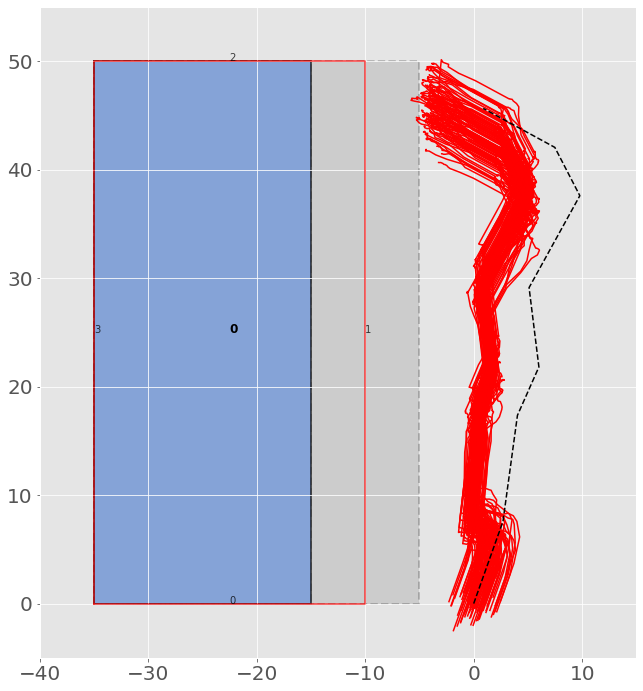

In [14]:
sim = Simulator(env)
sim.set_motion(A, B)
sim.set_obs(R)
sim.set_gain(lqr_planner.gain)
sim.set_init_est(x_est_0, P_est_0)
num_iters = 100
xs, x_ests, x_bars, prob_collision = sim.run(num_iters, x0, P_est_0, x_noms, u_noms, Qs_scaled)

env.plot()
Point(x0[0],x0[1]).plot()
sim.plot_trajs(xs, x_noms)

# Env 1

In [2]:
x_lims = [-10,10]
y_lims = [-5,5]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -6.5,-3,3,5,0)
rec_1 = Rectangle(1, 1,-1,3,3,0)
rec_2 = Rectangle(2, -10,5,20,1,0)
rec_3 = Rectangle(3, -10,-6.5,20,1,0)

rec_0.set_error_bounds(np.array([0,0,0,0]), np.array([0,1.5,1.5,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1.5,1]))
rec_2.set_error_bounds(np.array([-0.5,0,0,0]), np.array([0,0,0,0]))

rec_0.set_actual_errors(np.array([0,0,1.5,0]))
rec_1.set_actual_errors(np.array([0,0,1.5,1]))
rec_2.set_actual_errors(np.array([-0.5,0,0,0]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3])

goal_region = Rectangle(-1, 6.5,2,2,2,0)

NameError: name 'ax' is not defined

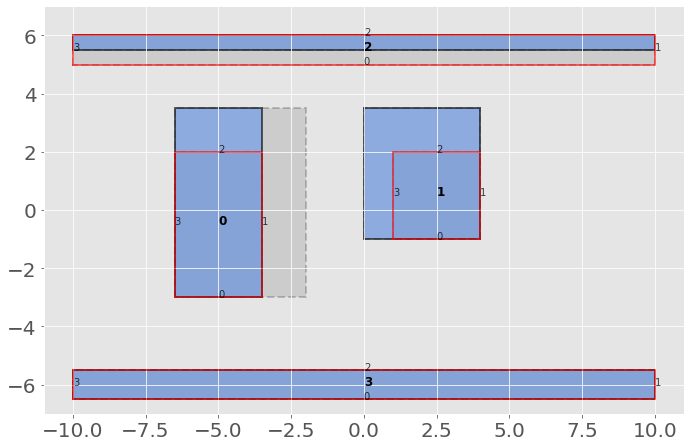

In [3]:
env.plot()
goal_region.plot(ax=ax,as_goal=True)
goal_region.as_poly["original"].plot(ax=ax)

In [4]:
dt = 0.2
A = np.eye(2); B = dt*np.eye(2)
Q_lqr = np.eye(2)
R_lqr = 0.1*np.eye(2)
lqr_planner = LQRPlanner(Q_lqr, R_lqr, A, B)

dx = 1
Q = np.eye(2) * 0.005
R = 0.1
T = 50
x0 = [-8, 2]

x_est_0 = x0
P_est_0 = 0.005* np.diag([(x_lims[1] - x_lims[0]), y_lims[1] - y_lims[0]])

In [5]:
samples_shortest = np.array([x0] + [[-7.5, 3]] + [[-6.5 + x, 4] for x in np.arange(0,14)] + [[7.5, 3]])
samples_medium = np.array([x0] + [[-7.5, 3]] + [[-6.5 + x, 4] for x in np.arange(0,6)] + [[-1, 3-y] for y in np.arange(0, 6)] + [[0+x, -2] for x in np.arange(0, 6)] + [[6, -1], [7,0], [7.5,1], [7.5, 2]]+ [[7.5, 3]])

In [57]:
x_range = np.array([x_lims, y_lims])
nsamples = 250
tol = 1e-2
g = Graph(x0, x_range, env, lqr_planner)
g.clear()
# g.set_samples(samples_shortest)
# g.set_samples(samples_medium)
g.set_samples(np.load("samples_env1.dat", allow_pickle=True))

In [60]:
g.build(nsamples, r=2, max_neighbors=3, tol=tol, motion_noise_ratio=0.05)

Connecting took: 0.35 s.


In [61]:
# g.samples.dump("samples_env1.dat")

In [ ]:
 [0, 96, 86, 76, 62, 44, 26, 27, 28, 29, 30, 31, 32, 50, 51, 33, 34, 35, 36, 54, 55, 69, 70, 80]

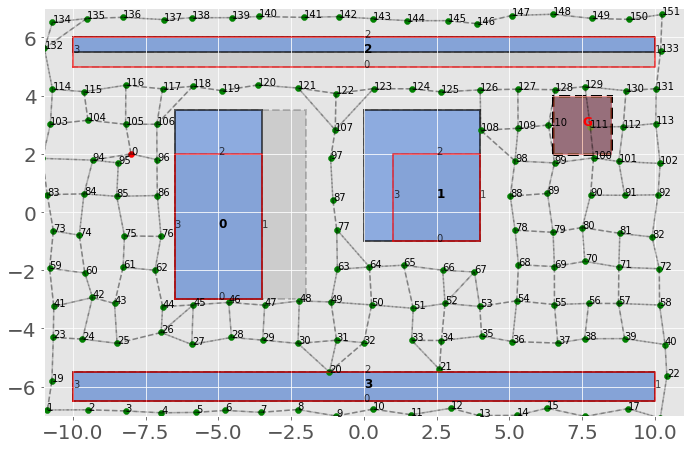

In [62]:
fig, ax = plt.subplots()
g.plot(ax=ax, show_idx=True)
goal_region.plot(ax=ax,as_goal=True)
goal_region.as_poly["original"].plot(ax=ax)

100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


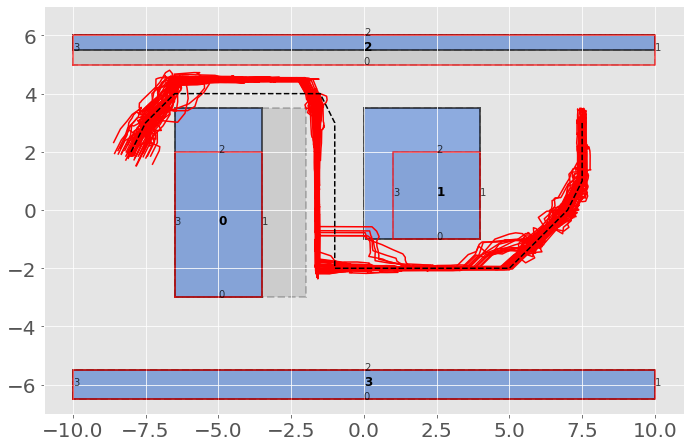

In [58]:
path_indices = [i for i in range(25)]
x_noms, u_noms, scales = GeoTools.indices2traj(path_indices, 2, 2, g)
sim = Simulator(env)
sim.set_motion(A, B)
sim.set_obs(R)
sim.set_gain(lqr_planner.gain)
sim.set_init_est(x_est_0, P_est_0)
num_iters = 50
xs, x_ests, x_bars, prob_collision = sim.run(num_iters, x0, P_est_0, x_noms, u_noms, scales)

env.plot()
Point(x0[0],x0[1]).plot()
sim.plot_trajs(xs, x_noms)

In [87]:
prob_collision

0.3

# Env 2

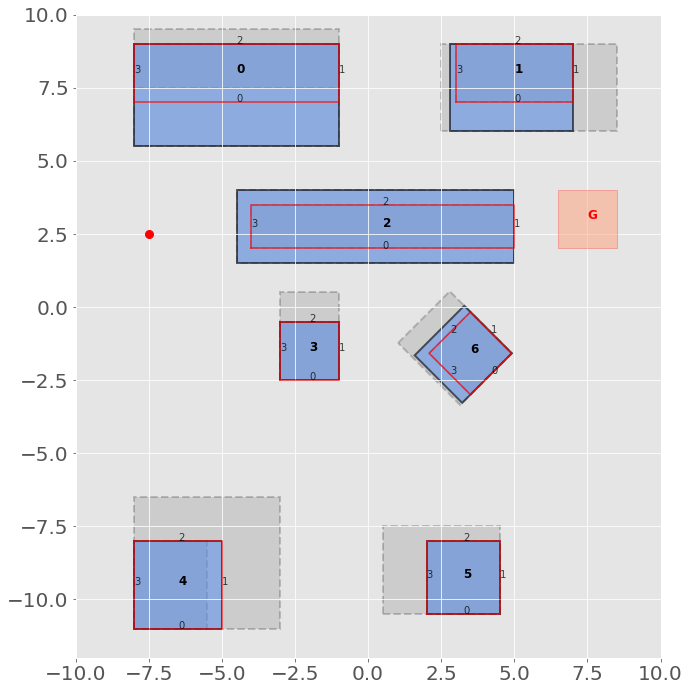

In [107]:
x_lims = [-10,10]
y_lims = [-12,10]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -8,7,7,2,0)
rec_1 = Rectangle(1, 3,7,4,2,0)
rec_2 = Rectangle(2, -4,2,9,1.5,0)
rec_3 = Rectangle(3, -3,-2.5,2,2,0)
rec_4 = Rectangle(4, -8,-11,3,3,0)
rec_5 = Rectangle(5, 2,-10.5,2.5,2.5,0)
rec_6 = Rectangle(6, 3.5,-3,2,2,45)

rec_0.set_error_bounds(np.array([-0.5,0,0,0]), np.array([1.5,0,0.5,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([1,1.5,0,0.5]))
rec_2.set_error_bounds(np.array([0,0,0,0]), np.array([0.5,0,0.5,0.5]))
rec_3.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1,0]))
rec_4.set_error_bounds(np.array([0,-0.5,0,0]), np.array([0,2,1.5,0]))
rec_5.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,0.5,1.5]))
rec_6.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1.0,0.5]))

rec_0.set_actual_errors(np.array([1.5,0,0,0]))
rec_1.set_actual_errors(np.array([1,0,0,0.2]))
rec_2.set_actual_errors(np.array([0.5,0,0.5,0.5]))
# rec_3.set_actual_errors(np.array([0,0,1,0]))
# rec_4.set_actual_errors(np.array([0,1,1,0]))
# rec_5.set_actual_errors(np.array([0,0,0,1]))
rec_6.set_actual_errors(np.array([0,0,0.3,0.4]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3, rec_4, rec_5, rec_6])

env.plot()
x_start = Point(-7.5, 2.5)
x_start.plot()
goal_region = Rectangle(-1, 6.5,2,2,2,0)
goal_region.plot(as_goal=True)

In [108]:
dt = 0.2
A = np.eye(2); B = dt*np.eye(2)
Q_lqr = np.eye(2)
R_lqr = 0.1*np.eye(2)
lqr_planner = LQRPlanner(Q_lqr, R_lqr, A, B)

dx = 1
Q = np.eye(2) * 0.005
R = 0.1
T = 50
x0 = [-8, 2]

x_est_0 = x0
P_est_0 = 0.005* np.diag([(x_lims[1] - x_lims[0]), y_lims[1] - y_lims[0]])

In [109]:
samples_shortest = np.array([x0] + [[-7.5, 3]] + [[-6.5, 3.8]] + [[-5.5 + x, 4.5] for x in np.arange(0,12)] + [[6.5, 4]] + [[7.5, 3]])
samples_shortest_2 = np.array([x0] + [[-7.5, 3-1.2]] + [[-6.5, 3.8-2.5]] + [[-5.5 + x, 4.5-3.5] for x in np.arange(0,12)] + [[6.5, 4-2.5]] + [[7.5, 3]])


In [118]:
x_range = np.array([x_lims, y_lims])
nsamples = 350
tol = 1e-2
g = Graph(x0, x_range, env, lqr_planner)
g.clear()
# g.set_samples(samples_shortest_2)
# g.set_samples(samples_medium)
# g.set_samples(new_samples)

In [124]:
g.samples.dump("samples_env2.dat")

In [122]:
g.build(nsamples, r=2, max_neighbors=3, tol=tol, motion_noise_ratio=0.05)

Connecting took: 0.74 s.


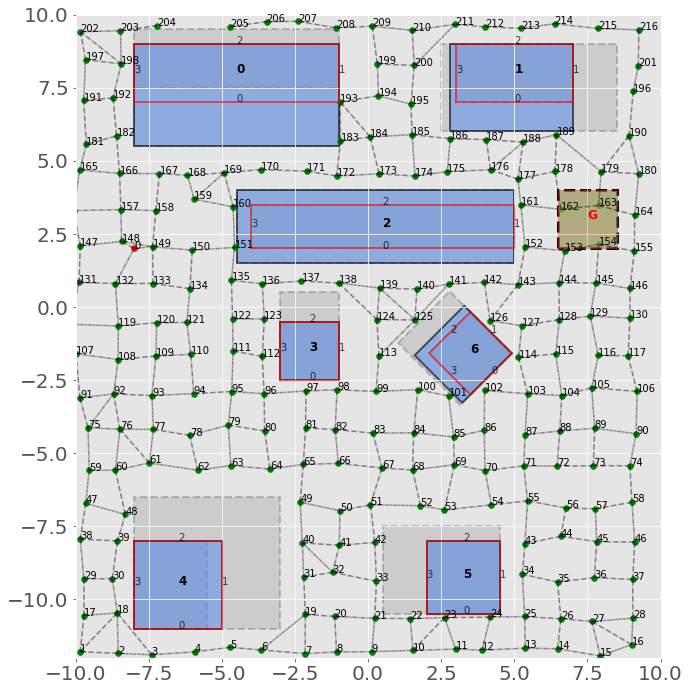

In [123]:
fig, ax = plt.subplots()
g.plot(ax=ax, show_idx=True)
goal_region.plot(ax=ax,as_goal=True)
goal_region.as_poly["original"].plot(ax=ax)

In [126]:
g.edges[0]

defaultdict(tuple, {148: (0.4870009698269305, array([[-8.     ,  2.     ],
                     [-8.20038,  2.10996],
                     [-8.30792,  2.16897],
                     [-8.36564,  2.20064],
                     [-8.39661,  2.21764],
                     [-8.41323,  2.22676],
                     [-8.42216,  2.23166],
                     [-8.42694,  2.23429]])),
             149: (0.6220026851605156, array([[-8.     ,  2.     ],
                     [-7.70944,  2.02826],
                     [-7.5535 ,  2.04343],
                     [-7.46981,  2.05157],
                     [-7.4249 ,  2.05594],
                     [-7.4008 ,  2.05828],
                     [-7.38786,  2.05954],
                     [-7.38092,  2.06021]])),
             132: (1.351742038573106, array([[-8.     ,  2.     ],
                     [-8.29762,  1.44401],
                     [-8.45734,  1.14562],
                     [-8.54306,  0.98549],
                     [-8.58906,  0.89954],
          

In [125]:
""" Initial estimates """
# We are confident about our initial estimate up to 0.5% of the environment size.
init_confidence = 0.5 / 100

x_est_0 = x0
P_est_0 = init_confidence * np.diag([(x_lims[1] - x_lims[0]), y_lims[1] - y_lims[0]])

""" Searcher """
horizon = 30  # After 30s, we assume the beginning is forgotten.
kmax = PlanUtils.get_kmax(dt, horizon)
lambda_coeff = 1.0
R = 0.1
searcher = Searcher(g, lambda_coeff * g.r)
searcher.set_source()
searcher.initialize_open(R, P_est_0, kmax)
searcher.set_goal(goal_region)

""" Explore """
prob_threshold = 0.01  # Safe = less than 1% chance of collision.
prune_portion = 0.1
t1 = time.time()
P_candidates, plan_found = searcher.explore(
    prob_threshold=prob_threshold,
    prune_portion=prune_portion,
    remove_dominated_parallel=False,
)
print("Terminated in {} s.".format(time.time() - t1))

I have detected 4 cores, I am going to use 2
Processing 1 plans


KeyboardInterrupt: 

100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


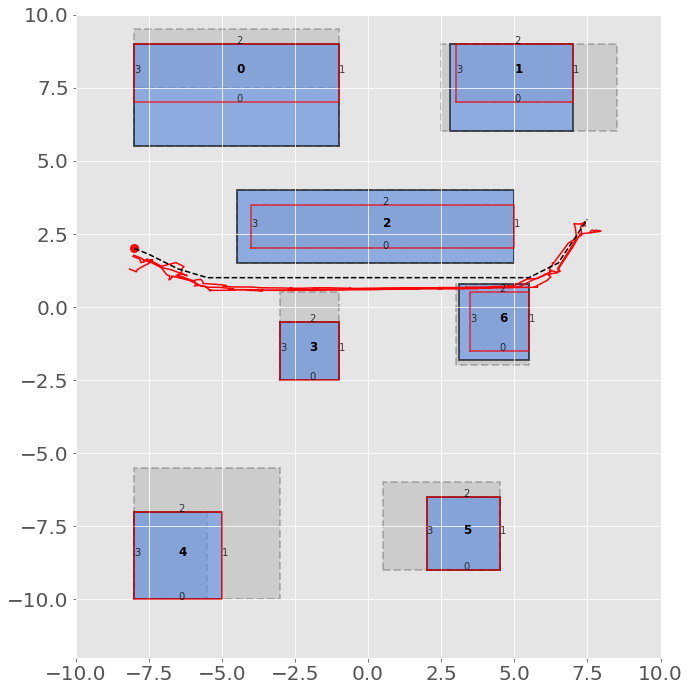

In [246]:
path_indices = [i for i in range(17)]
x_noms, u_noms, scales = GeoTools.indices2traj(path_indices, 2, 2, g)
sim = Simulator(env)
sim.set_motion(A, B)
sim.set_obs(R)
sim.set_gain(lqr_planner.gain)
sim.set_init_est(x_est_0, P_est_0)
num_iters = 3
xs, x_ests, x_bars, prob_collision = sim.run(num_iters, x0, P_est_0, x_noms, u_noms, scales)

env.plot()
Point(x0[0],x0[1]).plot()
sim.plot_trajs(xs, x_noms)